In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pickle, warnings, datetime, gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
warnings.filterwarnings('ignore')

In [2]:
with open('../../data/processed/gdelt_intermediate_cleaned.pkl', 'rb') as f:
    df = pickle.load(f)
df.drop_duplicates(subset=['GKGRECORDID'], inplace=True)

We perform PCA on 3 subsets of the data:
1. The 7 GKG1 columns: Tone, Positive Score, Negative Score, Polarity, Activity Reference Density, Self/Group Reference Density, Word Count
2. The 40 GKG2 columns that use a scored value
3. The 2410 GKG2 columns that use word count

For the third subset, we use Incremental PCA due to RAM limitations.

In [3]:
# Make cumulative explained variance plots for each PCA fit
def plot_cumulative_explained_variance(pca_fit, title):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_fit.explained_variance_ratio_), marker='o')
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

In [4]:
columns_to_drop = [
        'V2SOURCECOMMONNAME',
        'V2DOCUMENTIDENTIFIER',
        'V1THEMES',
        'datetime',
        'date',
        'airplane',
        'airline',
        'airport',
        'Alaska Airlines',
        'American Airlines',
        'Delta Air Lines',
        'Frontier Airlines',
        'Hawaiian Airlines',
        'JetBlue',
        'Southwest Airlines',
        'Spirit Airlines',
        'Sun Country Airlines',
        'United Airlines',
        'Allegiant Air',
        'article_title']

df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Preprocessing
df.index = df['GKGRECORDID']
df.drop(columns=['GKGRECORDID'], inplace=True)

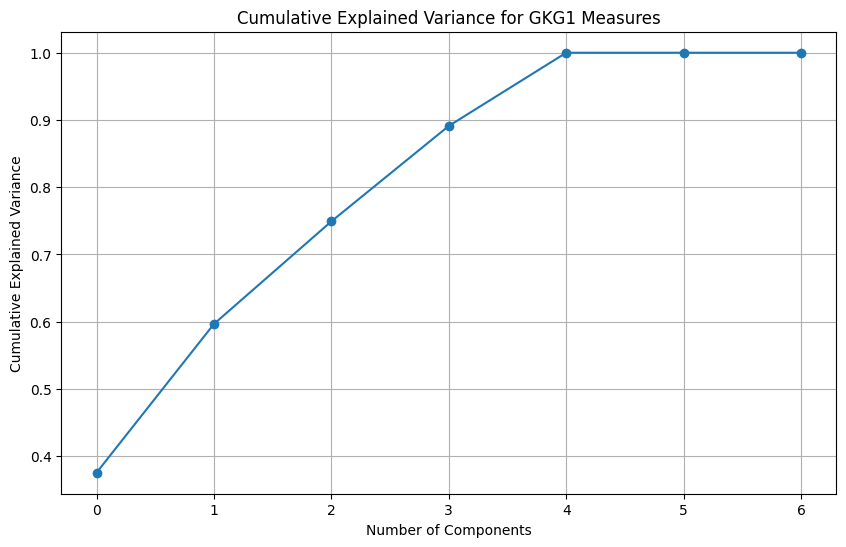

In [6]:
# Subset 1
df_1 = df[['Tone',
 'Positive Score',
 'Negative Score',
 'Polarity',
 'Activity Reference Density',
 'Self/Group Reference Density',
 'Word Count']]
columns = df_1.columns

scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
pca_fit = PCA().fit(df_1)
with open(r'../../data/processed/pca_fit_1.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG1 Measures')

df_1 = df[['Tone',
 'Positive Score',
 'Negative Score',
 'Polarity',
 'Activity Reference Density',
 'Self/Group Reference Density',
 'Word Count']]

# Use the PCA fit to create components for each row
for i in range(len(pca_fit.components_)):
    weights = pca_fit.components_[i]
    df[f'PCA_GKG1_{i}'] = np.matmul(df_1, pca_fit.components_[i])
    # This does a row-wise dot product between the GKG1 data and the PCA component weights

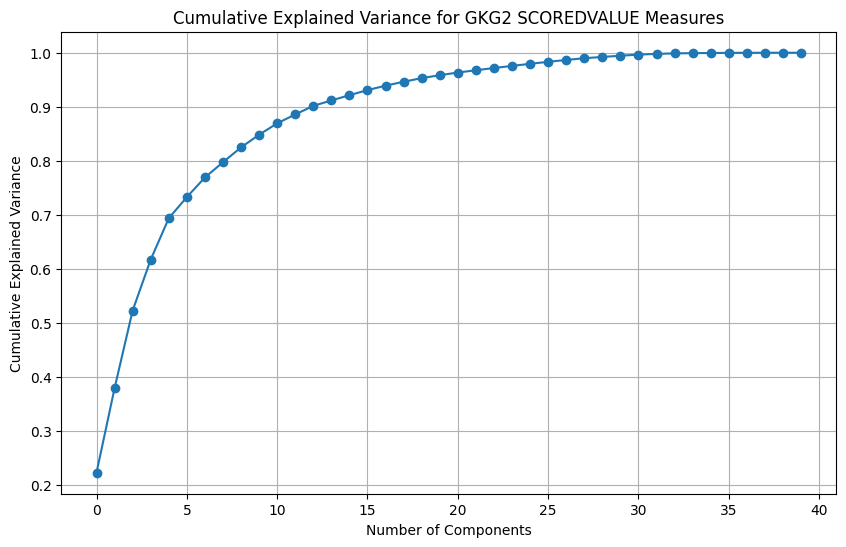

In [7]:
# Subset 2
df_1 = df.filter(regex='SCOREDVALUE')
columns = df_1.columns

scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
pca_fit = PCA().fit(df_1)
with open(r'../../data/processed/pca_fit_2.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG2 SCOREDVALUE Measures')

df_1 = df.filter(regex='SCOREDVALUE')

for i in range(len(pca_fit.components_)):
    weights = pca_fit.components_[i]
    df[f'PCA_Scored_{i}'] = np.matmul(df_1, pca_fit.components_[i])

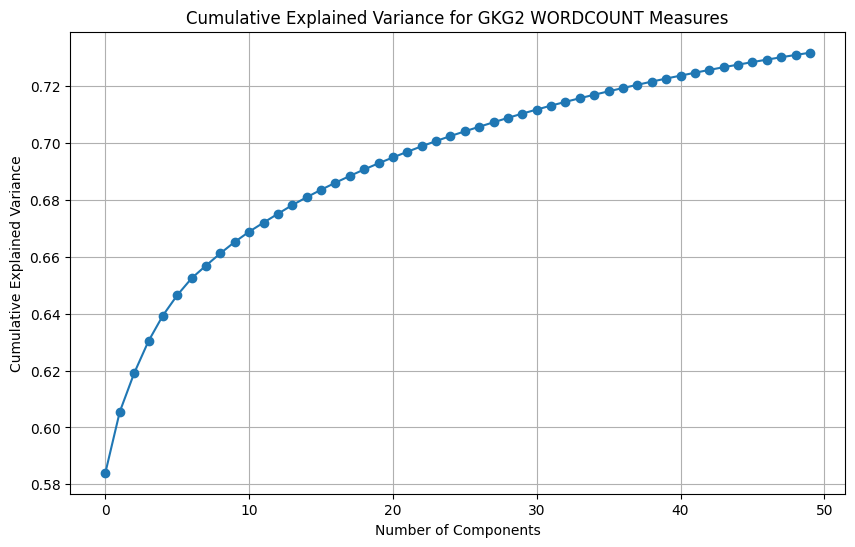

In [8]:
# Subset 3
df_1 = df.filter(regex='WORDCOUNT')
columns = df_1.columns

scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
pca_fit = IncrementalPCA(n_components=50, batch_size=200000).fit(df_1)
with open(r'../../data/processed/pca_fit_3.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG2 WORDCOUNT Measures')

df_1 = df.filter(regex='WORDCOUNT')

In [9]:
# To save time, just use the first n components
for i in range(50):
    weights = pca_fit.components_[i]
    df[f'PCA_Word_{i}'] = np.matmul(df_1, pca_fit.components_[i])

In [10]:
df = df.filter(regex='PCA_')
df.to_pickle('../../data/processed/gdelt_pca.pkl')